In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import requests
import json
import dateutil
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
plt.rcParams["figure.figsize"] = [10, 10]

In [3]:
age_df = pd.read_csv('../data/India/AgeGroupDetails.csv')

In [4]:
age_df.head(10)

,Sno,AgeGroup,TotalCases,Percentage
0,1,0-9,22,3.18%
1,2,10-19,27,3.90%
2,3,20-29,172,24.86%
3,4,30-39,146,21.10%
4,5,40-49,112,16.18%
5,6,50-59,77,11.13%
6,7,60-69,89,12.86%
7,8,70-79,28,4.05%
8,9,>=80,10,1.45%
9,10,Missing,9,1.30%


In [5]:
datetime_parser = lambda dt: datetime.strptime(x, '%Y-%m-%d %H:%M')

In [6]:
covid_df = pd.read_csv('../data/India/covid_19_india.csv', index_col='Sno')

In [7]:
covid_df.tail(20)

,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
Sno,,,,,,,,
2539,01/06/20,8:00 AM,Kerala,-,-,590,9,1269
2540,01/06/20,8:00 AM,Ladakh,-,-,43,0,74
2541,01/06/20,8:00 AM,Madhya Pradesh,-,-,4842,350,8089
2542,01/06/20,8:00 AM,Maharashtra,-,-,29329,2286,67655
2543,01/06/20,8:00 AM,Manipur,-,-,11,0,71
2544,01/06/20,8:00 AM,Meghalaya,-,-,12,1,27
2545,01/06/20,8:00 AM,Mizoram,-,-,1,0,1
2546,01/06/20,8:00 AM,Nagaland,-,-,0,0,43
2547,01/06/20,8:00 AM,Odisha,-,-,1126,7,1948


In [8]:
hosp_df = pd.read_csv('../data/India/HospitalBedsIndia.csv')
hosp_df.head()

,Sno,State/UT,NumPrimaryHealthCenters_HMIS,NumCommunityHealthCenters_HMIS,NumSubDistrictHospitals_HMIS,NumDistrictHospitals_HMIS,TotalPublicHealthFacilities_HMIS,NumPublicBeds_HMIS,NumRuralHospitals_NHP18,NumRuralBeds_NHP18,NumUrbanHospitals_NHP18,NumUrbanBeds_NHP18
0,1,Andaman & Nicobar Islands,27,4,NaN,3,34,1246,27,575,3,500
1,2,Andhra Pradesh,1417,198,31.0,20,1666,60799,193,6480,65,16658
2,3,Arunachal Pradesh,122,62,NaN,15,199,2320,208,2136,10,268
3,4,Assam,1007,166,14.0,33,1220,19115,1176,10944,50,6198
4,5,Bihar,2007,63,33.0,43,2146,17796,930,6083,103,5936


In [9]:
icmr_df = pd.read_csv('../data/India/ICMRTestingLabs.csv')
icmr_df.head()

,lab,address,pincode,city,state,type
0,"ICMR-Regional Medical Research Centre, Port Blair","ICMR-Regional Medical Research Centre, Post Ba...",744103,Port Blair,Andaman and Nicobar Islands,Government Laboratory
1,Tomo Riba Institute of Health & Medical Scienc...,"National Highway 52A, Old Assembly Complex, Na...",791110,Naharlagun,Arunachal Pradesh,Collection Site
2,Sri Venkateswara Institute of Medical Sciences...,Sri Venkateswara Institute of Medical Sciences...,517507,Tirupati,Andhra Pradesh,Government Laboratory
3,"Rangaraya Medical College, Kakinada","Rangaraya Medical College, Kakinada Pithampura...",533001,Kakinada,Andhra Pradesh,Government Laboratory
4,"Sidhartha Medical College, Vijaywada","Siddhartha Medical College, Vijayawada NH 16 S...",520008,Vijayawada,Andhra Pradesh,Government Laboratory


In [10]:
patients_df = pd.read_csv('../data/India/IndividualDetails.csv')
patients_df.head()

,id,government_id,diagnosed_date,age,gender,detected_city,detected_district,detected_state,nationality,current_status,status_change_date,notes
0,0,KL-TS-P1,30/01/2020,20,F,Thrissur,Thrissur,Kerala,India,Recovered,14/02/2020,Travelled from Wuhan
1,1,KL-AL-P1,02/02/2020,NaN,NaN,Alappuzha,Alappuzha,Kerala,India,Recovered,14/02/2020,Travelled from Wuhan
2,2,KL-KS-P1,03/02/2020,NaN,NaN,Kasaragod,Kasaragod,Kerala,India,Recovered,14/02/2020,Travelled from Wuhan
3,3,DL-P1,02/03/2020,45,M,East Delhi (Mayur Vihar),East Delhi,Delhi,India,Recovered,15/03/2020,"Travelled from Austria, Italy"
4,4,TS-P1,02/03/2020,24,M,Hyderabad,Hyderabad,Telangana,India,Recovered,02/03/2020,"Travelled from Dubai to Bangalore on 20th Feb,..."


In [11]:
patients_data = "https://api.covid19india.org/raw_data%d.json"
list_json_data = []

for i in range(1, 7):
    json_response = requests.get(patients_data % i).text
    list_of_patients = json.loads(json_response)['raw_data']
    list_json_data.extend(list_of_patients)

In [12]:
list_json_data[1]

{'agebracket': '',
 'backupnotes': 'Student from Wuhan',
 'contractedfromwhichpatientsuspected': '',
 'currentstatus': 'Recovered',
 'dateannounced': '02/02/2020',
 'detectedcity': 'Alappuzha',
 'detecteddistrict': 'Alappuzha',
 'detectedstate': 'Kerala',
 'estimatedonsetdate': '',
 'gender': '',
 'nationality': 'India',
 'notes': 'Travelled from Wuhan',
 'numcases': '1',
 'patientnumber': '2',
 'source1': 'https://www.indiatoday.in/india/story/kerala-reports-second-case-of-coronavirus-1642494-2020-02-02',
 'source2': 'https://weather.com/en-IN/india/news/news/2020-02-14-kerala-defeats-coronavirus-indias-three-covid-19-patients-successfully',
 'source3': '',
 'statecode': 'KL',
 'statepatientnumber': 'KL-AL-P1',
 'statuschangedate': '14/02/2020',
 'typeoftransmission': 'Imported'}

In [13]:
new_patients_df = pd.DataFrame(list_json_data)
new_patients_df.head(5)

,agebracket,backupnotes,contractedfromwhichpatientsuspected,currentstatus,dateannounced,detectedcity,detecteddistrict,detectedstate,entryid,estimatedonsetdate,...,notes,numcases,patientnumber,source1,source2,source3,statecode,statepatientnumber,statuschangedate,typeoftransmission
0,20,Student from Wuhan,,Recovered,30/01/2020,Thrissur,Thrissur,Kerala,NaN,,...,Travelled from Wuhan,1,1,https://twitter.com/vijayanpinarayi/status/122...,https://weather.com/en-IN/india/news/news/2020...,,KL,KL-TS-P1,14/02/2020,Imported
1,,Student from Wuhan,,Recovered,02/02/2020,Alappuzha,Alappuzha,Kerala,NaN,,...,Travelled from Wuhan,1,2,https://www.indiatoday.in/india/story/kerala-r...,https://weather.com/en-IN/india/news/news/2020...,,KL,KL-AL-P1,14/02/2020,Imported
2,,Student from Wuhan,,Recovered,03/02/2020,Kasaragod,Kasaragod,Kerala,NaN,,...,Travelled from Wuhan,1,3,https://www.indiatoday.in/india/story/kerala-n...,https://twitter.com/ANI/status/122422148580539...,https://weather.com/en-IN/india/news/news/2020...,KL,KL-KS-P1,14/02/2020,Imported
3,45,Travel history to Italy and Austria,,Recovered,02/03/2020,East Delhi (Mayur Vihar),East Delhi,Delhi,NaN,,...,"Travelled from Austria, Italy",1,4,https://www.indiatoday.in/india/story/not-a-ja...,https://economictimes.indiatimes.com/news/poli...,,DL,DL-P1,15/03/2020,Imported
4,24,"Travel history to Dubai, Singapore contact",,Recovered,02/03/2020,Hyderabad,Hyderabad,Telangana,NaN,,...,"Travelled from Dubai to Bangalore on 20th Feb,...",1,5,https://www.deccanherald.com/national/south/qu...,https://www.indiatoday.in/india/story/coronavi...,https://www.thehindu.com/news/national/coronav...,TG,TS-P1,02/03/2020,Imported


In [14]:
new_patients_df.to_csv('new_patients_data.csv')

In [15]:
state_testing_df = pd.read_csv('../data/India/StatewiseTestingDetails.csv')
state_testing_df.head()

,Date,State,TotalSamples,Negative,Positive
0,2020-04-17,Andaman and Nicobar Islands,1403.0,1210.0,12.0
1,2020-04-24,Andaman and Nicobar Islands,2679.0,NaN,27.0
2,2020-04-27,Andaman and Nicobar Islands,2848.0,NaN,33.0
3,2020-05-01,Andaman and Nicobar Islands,3754.0,NaN,33.0
4,2020-05-16,Andaman and Nicobar Islands,6677.0,NaN,33.0


In [16]:
census_df = pd.read_csv('../data/India/population_india_census2011.csv')
census_df.head()

,Sno,State / Union Territory,Population,Rural population,Urban population,Area,Density,Gender Ratio
0,1,Uttar Pradesh,199812341,155317278,44495063,"240,928 km2 (93,023 sq mi)","828/km2 (2,140/sq mi)",912
1,2,Maharashtra,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929
2,3,Bihar,104099452,92341436,11758016,"94,163 km2 (36,357 sq mi)","1,102/km2 (2,850/sq mi)",918
3,4,West Bengal,91276115,62183113,29093002,"88,752 km2 (34,267 sq mi)","1,029/km2 (2,670/sq mi)",953
4,5,Madhya Pradesh,72626809,52557404,20069405,"308,245 km2 (119,014 sq mi)",236/km2 (610/sq mi),931


### Data Cleaning

#### I. Covid 19 Data Frame

In [17]:
covid_df = pd.read_csv('../data/India/covid_19_india.csv', index_col='Sno')

In [18]:
covid_df.dtypes

Date                        object
Time                        object
State/UnionTerritory        object
ConfirmedIndianNational     object
ConfirmedForeignNational    object
Cured                        int64
Deaths                       int64
Confirmed                    int64
dtype: object

In [19]:
covid_df.Date = pd.to_datetime(covid_df.Date, format='%d/%m/%y')

In [20]:
covid_df.head(20)

,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
Sno,,,,,,,,
1,2020-01-30,6:00 PM,Kerala,1,0,0,0,1
2,2020-01-31,6:00 PM,Kerala,1,0,0,0,1
3,2020-02-01,6:00 PM,Kerala,2,0,0,0,2
4,2020-02-02,6:00 PM,Kerala,3,0,0,0,3
5,2020-02-03,6:00 PM,Kerala,3,0,0,0,3
6,2020-02-04,6:00 PM,Kerala,3,0,0,0,3
7,2020-02-05,6:00 PM,Kerala,3,0,0,0,3
8,2020-02-06,6:00 PM,Kerala,3,0,0,0,3
9,2020-02-07,6:00 PM,Kerala,3,0,0,0,3


In [21]:
covid_df = covid_df.rename(columns={"State/UnionTerritory": "State"})

In [22]:
covid_df.loc[:, 'Active'] = covid_df.loc[:, 'Confirmed'] - covid_df.loc[:, 'Deaths'] - covid_df.loc[:, 'Cured']

In [23]:
covid_df = covid_df[['Date', 'State', 'Cured', 'Deaths', 'Confirmed', 'Active']]

In [24]:
covid_df.head()

,Date,State,Cured,Deaths,Confirmed,Active
Sno,,,,,,
1,2020-01-30,Kerala,0,0,1,1
2,2020-01-31,Kerala,0,0,1,1
3,2020-02-01,Kerala,0,0,2,2
4,2020-02-02,Kerala,0,0,3,3
5,2020-02-03,Kerala,0,0,3,3


In [25]:
covid_df.loc[:, "Fatality Rate"] = covid_df['Deaths'] / covid_df['Cured'] * 100

In [26]:
covid_df.tail()

,Date,State,Cured,Deaths,Confirmed,Active,Fatality Rate
Sno,,,,,,,
2554,2020-06-01,Tripura,173,0,313,140,0.000000
2555,2020-06-01,Uttarakhand,102,5,907,800,4.901961
2556,2020-06-01,Uttar Pradesh,4709,213,7823,2901,4.523253
2557,2020-06-01,West Bengal,2157,317,5501,3027,14.696338
2558,2020-06-01,Cases being reassigned to states,0,0,5630,5630,NaN


In [27]:
covid_df = covid_df[~(covid_df.State == 'Cases being reassigned to states')]

In [28]:
latest_df = covid_df[covid_df.Date == '2020-06-01']

### Top 10 States with Max Fatalities

In [29]:
latest_df = latest_df.sort_values(by='Deaths', ascending=False)

In [30]:
top_10_states_with_highest_fatalities = latest_df[:10]

In [31]:
top_10_states_with_highest_fatalities.head()

,Date,State,Cured,Deaths,Confirmed,Active,Fatality Rate
Sno,,,,,,,
2542,2020-06-01,Maharashtra,29329,2286,67655,36040,7.794333
2533,2020-06-01,Gujarat,9919,1038,16779,5822,10.464765
2531,2020-06-01,Delhi,8478,473,19844,10893,5.579146
2541,2020-06-01,Madhya Pradesh,4842,350,8089,2897,7.228418
2557,2020-06-01,West Bengal,2157,317,5501,3027,14.696338


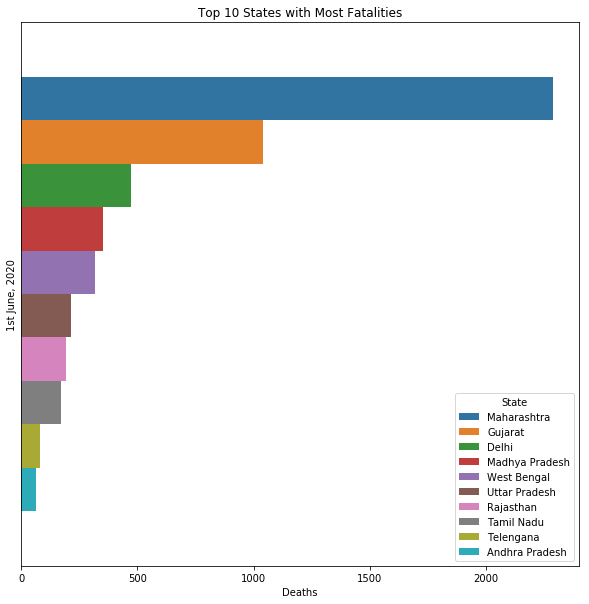

In [32]:
sns.barplot(y=top_10_states_with_highest_fatalities.Date, x=top_10_states_with_highest_fatalities.Deaths, hue=top_10_states_with_highest_fatalities.State, orient='h')
plt.title('Top 10 States with Most Fatalities')
plt.ylabel('1st June, 2020')
plt.yticks([])
plt.show()

### Top 10 States with Highest Fatality Rates

In [33]:
latest_df = latest_df.sort_values(by='Fatality Rate', ascending=False)

In [34]:
top_10_states_with_highest_fatality_rate = latest_df[:10]

In [35]:
top_10_states_with_highest_fatality_rate.head()

,Date,State,Cured,Deaths,Confirmed,Active,Fatality Rate
Sno,,,,,,,
2557,2020-06-01,West Bengal,2157,317,5501,3027,14.696338
2533,2020-06-01,Gujarat,9919,1038,16779,5822,10.464765
2544,2020-06-01,Meghalaya,12,1,27,14,8.333333
2542,2020-06-01,Maharashtra,29329,2286,67655,36040,7.794333
2541,2020-06-01,Madhya Pradesh,4842,350,8089,2897,7.228418


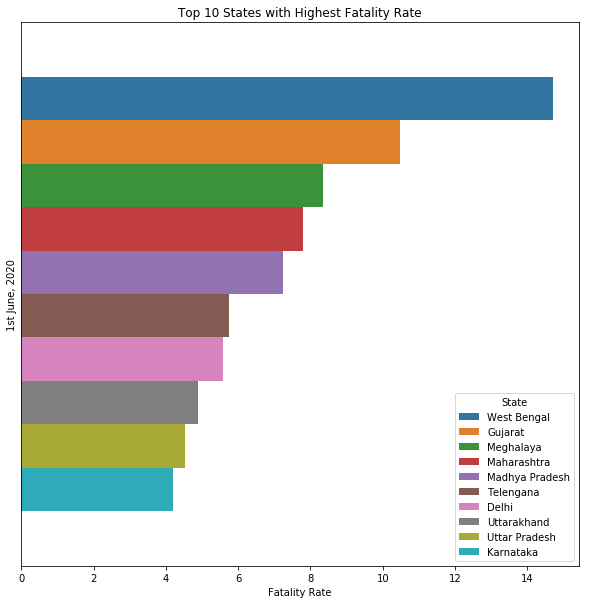

In [36]:
sns.barplot(y=top_10_states_with_highest_fatality_rate.Date, x=top_10_states_with_highest_fatality_rate['Fatality Rate'], hue=top_10_states_with_highest_fatality_rate.State, orient='h')
plt.title('Top 10 States with Highest Fatality Rate')
plt.ylabel('1st June, 2020')
plt.yticks([])
plt.show()

### Finding

- Maharashtra, having the highest number of fatalities due to Covid-19, has 4th highest mortality rate, since rate of recovery is high.
- West Bengal, having 5th highest number of fatalities, has highest mortality rate.

In [37]:
top_7_states = ["Maharashtra", 'Gujarat', 'Madhya Pradesh', 'Delhi', 'Madhya Pradesh', 'West Bengal', 'Uttar Pradesh']

In [38]:
top_7_states_df = covid_df[covid_df.State.isin(top_7_states)]
top_7_states_df.head()

,Date,State,Cured,Deaths,Confirmed,Active,Fatality Rate
Sno,,,,,,,
35,2020-03-02,Delhi,0,0,1,1,NaN
39,2020-03-03,Delhi,0,0,1,1,NaN
40,2020-03-04,Uttar Pradesh,0,0,6,6,NaN
43,2020-03-04,Delhi,0,0,1,1,NaN
46,2020-03-05,Delhi,0,0,2,2,NaN


In [39]:
top_7_states_df = top_7_states_df.set_index('Date')

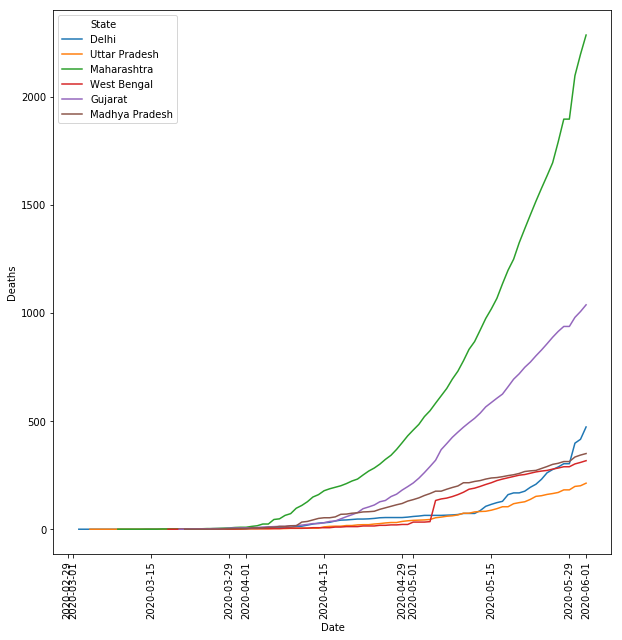

In [40]:
sns.lineplot(x=top_7_states_df.index, y=top_7_states_df.Deaths, hue=top_7_states_df.State)
plt.xticks(rotation=90)
plt.show()

#### Finding:

- Uttar Pradesh, having highest population amongst Indian states has least number of fatalities.

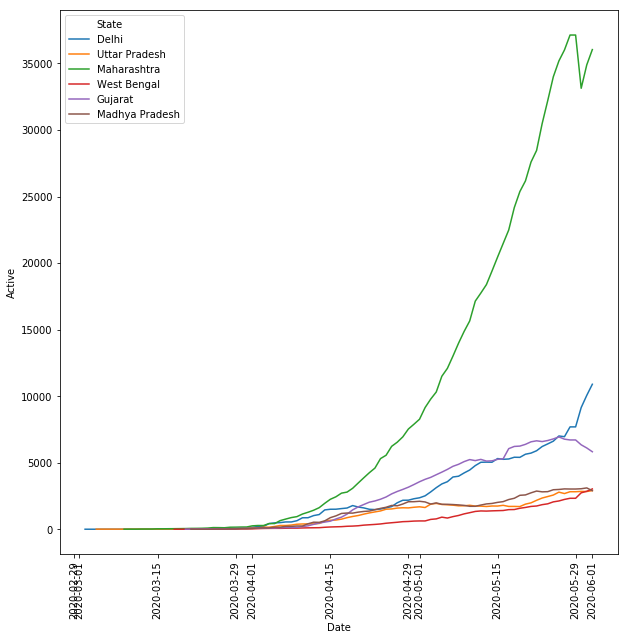

In [41]:
sns.lineplot(x=top_7_states_df.index, y=top_7_states_df.Active, hue=top_7_states_df.State)
plt.xticks(rotation=90)
plt.show()

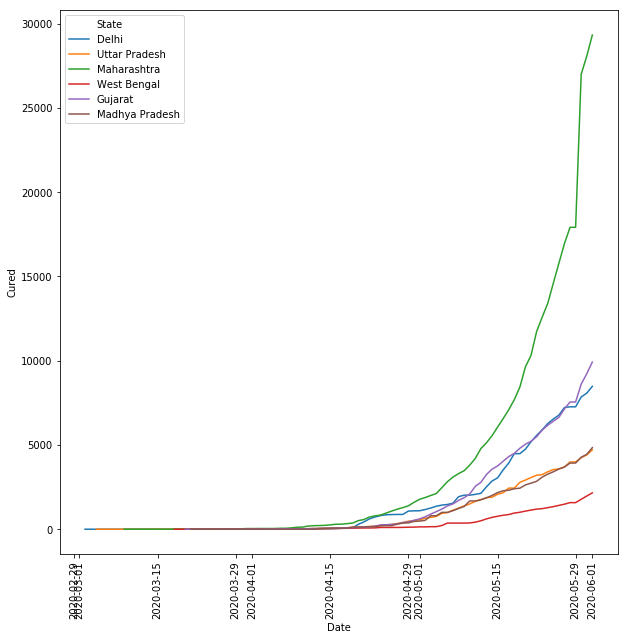

In [42]:
sns.lineplot(x=top_7_states_df.index, y=top_7_states_df.Cured, hue=top_7_states_df.State)
plt.xticks(rotation=90)
plt.show()

#### Finding:
- West Bengal is one of the states with least recovery rate.

#### Patients Df

In [43]:
new_patients_df = pd.DataFrame(list_json_data)

In [44]:
new_patients_df.head()

,agebracket,backupnotes,contractedfromwhichpatientsuspected,currentstatus,dateannounced,detectedcity,detecteddistrict,detectedstate,entryid,estimatedonsetdate,...,notes,numcases,patientnumber,source1,source2,source3,statecode,statepatientnumber,statuschangedate,typeoftransmission
0,20,Student from Wuhan,,Recovered,30/01/2020,Thrissur,Thrissur,Kerala,NaN,,...,Travelled from Wuhan,1,1,https://twitter.com/vijayanpinarayi/status/122...,https://weather.com/en-IN/india/news/news/2020...,,KL,KL-TS-P1,14/02/2020,Imported
1,,Student from Wuhan,,Recovered,02/02/2020,Alappuzha,Alappuzha,Kerala,NaN,,...,Travelled from Wuhan,1,2,https://www.indiatoday.in/india/story/kerala-r...,https://weather.com/en-IN/india/news/news/2020...,,KL,KL-AL-P1,14/02/2020,Imported
2,,Student from Wuhan,,Recovered,03/02/2020,Kasaragod,Kasaragod,Kerala,NaN,,...,Travelled from Wuhan,1,3,https://www.indiatoday.in/india/story/kerala-n...,https://twitter.com/ANI/status/122422148580539...,https://weather.com/en-IN/india/news/news/2020...,KL,KL-KS-P1,14/02/2020,Imported
3,45,Travel history to Italy and Austria,,Recovered,02/03/2020,East Delhi (Mayur Vihar),East Delhi,Delhi,NaN,,...,"Travelled from Austria, Italy",1,4,https://www.indiatoday.in/india/story/not-a-ja...,https://economictimes.indiatimes.com/news/poli...,,DL,DL-P1,15/03/2020,Imported
4,24,"Travel history to Dubai, Singapore contact",,Recovered,02/03/2020,Hyderabad,Hyderabad,Telangana,NaN,,...,"Travelled from Dubai to Bangalore on 20th Feb,...",1,5,https://www.deccanherald.com/national/south/qu...,https://www.indiatoday.in/india/story/coronavi...,https://www.thehindu.com/news/national/coronav...,TG,TS-P1,02/03/2020,Imported


In [45]:
new_patients_df.dtypes

agebracket                             object
backupnotes                            object
contractedfromwhichpatientsuspected    object
currentstatus                          object
dateannounced                          object
detectedcity                           object
detecteddistrict                       object
detectedstate                          object
entryid                                object
estimatedonsetdate                     object
gender                                 object
nationality                            object
notes                                  object
numcases                               object
patientnumber                          object
source1                                object
source2                                object
source3                                object
statecode                              object
statepatientnumber                     object
statuschangedate                       object
typeoftransmission                

In [46]:
new_patients_df[new_patients_df['numcases'] == ''] = 0

In [47]:
new_patients_df[new_patients_df['patientnumber'] == ''] = 0

In [48]:
new_patients_df[['numcases', 'patientnumber']] = new_patients_df[['numcases', 'patientnumber']].astype(int)

In [50]:
new_patients_df.head()

,agebracket,backupnotes,contractedfromwhichpatientsuspected,currentstatus,dateannounced,detectedcity,detecteddistrict,detectedstate,entryid,estimatedonsetdate,...,notes,numcases,patientnumber,source1,source2,source3,statecode,statepatientnumber,statuschangedate,typeoftransmission
0,20,Student from Wuhan,,Recovered,30/01/2020,Thrissur,Thrissur,Kerala,NaN,,...,Travelled from Wuhan,1,1,https://twitter.com/vijayanpinarayi/status/122...,https://weather.com/en-IN/india/news/news/2020...,,KL,KL-TS-P1,14/02/2020,Imported
1,,Student from Wuhan,,Recovered,02/02/2020,Alappuzha,Alappuzha,Kerala,NaN,,...,Travelled from Wuhan,1,2,https://www.indiatoday.in/india/story/kerala-r...,https://weather.com/en-IN/india/news/news/2020...,,KL,KL-AL-P1,14/02/2020,Imported
2,,Student from Wuhan,,Recovered,03/02/2020,Kasaragod,Kasaragod,Kerala,NaN,,...,Travelled from Wuhan,1,3,https://www.indiatoday.in/india/story/kerala-n...,https://twitter.com/ANI/status/122422148580539...,https://weather.com/en-IN/india/news/news/2020...,KL,KL-KS-P1,14/02/2020,Imported
3,45,Travel history to Italy and Austria,,Recovered,02/03/2020,East Delhi (Mayur Vihar),East Delhi,Delhi,NaN,,...,"Travelled from Austria, Italy",1,4,https://www.indiatoday.in/india/story/not-a-ja...,https://economictimes.indiatimes.com/news/poli...,,DL,DL-P1,15/03/2020,Imported
4,24,"Travel history to Dubai, Singapore contact",,Recovered,02/03/2020,Hyderabad,Hyderabad,Telangana,NaN,,...,"Travelled from Dubai to Bangalore on 20th Feb,...",1,5,https://www.deccanherald.com/national/south/qu...,https://www.indiatoday.in/india/story/coronavi...,https://www.thehindu.com/news/national/coronav...,TG,TS-P1,02/03/2020,Imported


In [51]:
new_patients_df_min = new_patients_df[['currentstatus', 'detectedcity', 
                                       'detecteddistrict', 'detectedstate',
                                      'gender', 'nationality', 'numcases', 'patientnumber', 'statepatientnumber'
                                       ,'typeoftransmission']]

In [52]:
new_patients_df_min.currentstatus.unique()

array(['Recovered', 'Hospitalized', 'Deceased', 'Migrated', 0,
       'Migrated_Other', ''], dtype=object)

In [53]:
new_patients_df_min.head()

,currentstatus,detectedcity,detecteddistrict,detectedstate,gender,nationality,numcases,patientnumber,statepatientnumber,typeoftransmission
0,Recovered,Thrissur,Thrissur,Kerala,F,India,1,1,KL-TS-P1,Imported
1,Recovered,Alappuzha,Alappuzha,Kerala,,India,1,2,KL-AL-P1,Imported
2,Recovered,Kasaragod,Kasaragod,Kerala,,India,1,3,KL-KS-P1,Imported
3,Recovered,East Delhi (Mayur Vihar),East Delhi,Delhi,M,India,1,4,DL-P1,Imported
4,Recovered,Hyderabad,Hyderabad,Telangana,M,India,1,5,TS-P1,Imported


In [54]:
new_patients_df_min[new_patients_df_min.currentstatus == 'Deceased'].head()

,currentstatus,detectedcity,detecteddistrict,detectedstate,gender,nationality,numcases,patientnumber,statepatientnumber,typeoftransmission
72,Deceased,Janakpuri,South West Delhi,Delhi,F,India,1,72,DL-P6,Local
76,Deceased,Mumbai,Mumbai,Maharashtra,M,India,1,77,,Imported
81,Deceased,Kalaburagi,Kalaburagi,Karnataka,M,India,1,74,KA-P6,Imported
181,Deceased,Banga,Shahid Bhagat Singh Nagar,Punjab,M,India,1,182,PJ-P2,Imported
269,Deceased,Mumbai,Mumbai,Maharashtra,M,India,1,270,,Imported


In [55]:
new_patients_df_min_deceased = new_patients_df_min[(new_patients_df_min.currentstatus == 'Deceased') & (new_patients_df_min.numcases > 0)]

In [56]:
new_patients_df_min_deceased = new_patients_df_min_deceased[~(new_patients_df_min_deceased.detecteddistrict == '')] 

### Top 5 districts with maximum fatalities in India

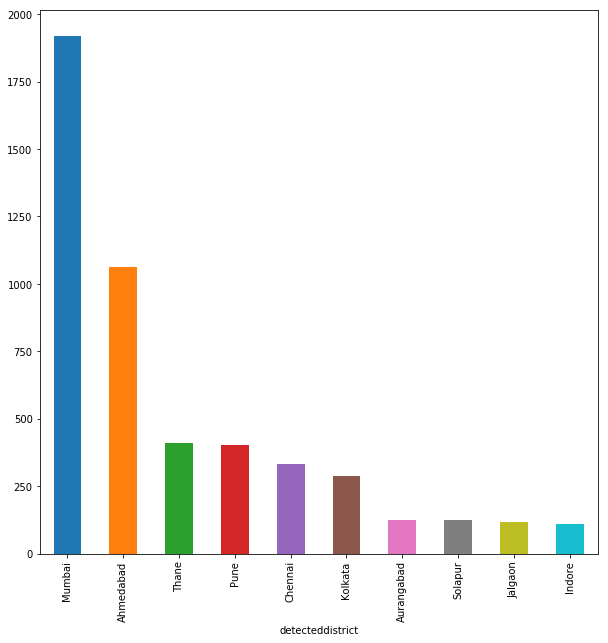

In [57]:
new_patients_df_min_deceased.groupby(['detecteddistrict'])['numcases'].sum().sort_values(ascending=False).head(10).plot(kind='bar')
plt.show()

### Statewise Testing

In [58]:
state_testing_df.dtypes

Date             object
State            object
TotalSamples    float64
Negative        float64
Positive        float64
dtype: object

In [59]:
state_testing_df.Date = pd.to_datetime(state_testing_df.Date, format='%Y-%m-%d')

In [60]:
state_testing_df = state_testing_df.set_index('Date')

In [61]:
state_testing_df.describe()

,TotalSamples,Negative,Positive
count,1600.000000,1270.000000,1591.000000
mean,53222.768750,53044.739370,2073.120679
std,82613.927507,83277.376599,5709.301438
min,58.000000,0.000000,0.000000
25%,3680.750000,3860.000000,33.000000
50%,16378.500000,15803.500000,287.000000
75%,65908.750000,62487.250000,1655.000000
max,491962.000000,468940.000000,65168.000000


In [62]:
state_testing_df.isna().sum()

State             0
TotalSamples      0
Negative        330
Positive          9
dtype: int64

In [63]:
state_testing_df[state_testing_df['Positive'].isna()]

,State,TotalSamples,Negative,Positive
Date,,,,
2020-05-31,Bihar,75737.0,NaN,NaN
2020-04-01,Delhi,2621.0,NaN,NaN
2020-04-05,Maharashtra,16008.0,14837.0,NaN
2020-04-04,West Bengal,1042.0,NaN,NaN
2020-04-06,West Bengal,1301.0,NaN,NaN
2020-04-07,West Bengal,1487.0,NaN,NaN
2020-04-09,West Bengal,1889.0,NaN,NaN
2020-04-10,West Bengal,2095.0,NaN,NaN
2020-05-01,West Bengal,18566.0,NaN,NaN


In [64]:
state_testing_df['Negative'] = state_testing_df['TotalSamples'] - state_testing_df['Positive']

In [65]:
state_testing_df.isna().sum()

State           0
TotalSamples    0
Negative        9
Positive        9
dtype: int64

In [66]:
state_testing_df = state_testing_df[~(state_testing_df.Positive.isna())]

In [67]:
covid_temp = covid_df

In [68]:
covid_temp = covid_temp.set_index('Date')

In [69]:
covid_temp.head()

,State,Cured,Deaths,Confirmed,Active,Fatality Rate
Date,,,,,,
2020-01-30,Kerala,0,0,1,1,NaN
2020-01-31,Kerala,0,0,1,1,NaN
2020-02-01,Kerala,0,0,2,2,NaN
2020-02-02,Kerala,0,0,3,3,NaN
2020-02-03,Kerala,0,0,3,3,NaN


In [70]:
merged_df = pd.merge(covid_temp, state_testing_df, how='inner', left_index=True, right_index=True, on='State')

In [71]:
merged_df.tail(20)

,State,Cured,Deaths,Confirmed,Active,Fatality Rate,TotalSamples,Negative,Positive
Date,,,,,,,,,
2020-05-31,West Bengal,1970,309,5130,2851,15.685279,171045.0,168599.0,2446.0
2020-05-31,West Bengal,1970,309,5130,2851,15.685279,65886.0,65276.0,610.0
2020-05-31,West Bengal,1970,309,5130,2851,15.685279,293575.0,290354.0,3221.0
2020-05-31,West Bengal,1970,309,5130,2851,15.685279,77508.0,76238.0,1270.0
2020-05-31,West Bengal,1970,309,5130,2851,15.685279,7354.0,7277.0,77.0
2020-05-31,West Bengal,1970,309,5130,2851,15.685279,167808.0,159719.0,8089.0
2020-05-31,West Bengal,1970,309,5130,2851,15.685279,463177.0,398009.0,65168.0
2020-05-31,West Bengal,1970,309,5130,2851,15.685279,7781.0,7754.0,27.0
2020-05-31,West Bengal,1970,309,5130,2851,15.685279,777.0,776.0,1.0


In [72]:
state_testing_df.loc['2020-05-31']

,State,TotalSamples,Negative,Positive
Date,,,,
2020-05-31,Andhra Pradesh,372748.0,369703.0,3045.0
2020-05-31,Assam,109097.0,107825.0,1272.0
2020-05-31,Chandigarh,4785.0,4492.0,293.0
2020-05-31,Chhattisgarh,69152.0,68660.0,492.0
2020-05-31,Delhi,212784.0,192940.0,19844.0
2020-05-31,Goa,19491.0,19420.0,71.0
2020-05-31,Haryana,118138.0,116047.0,2091.0
2020-05-31,Himachal Pradesh,37168.0,36837.0,331.0
2020-05-31,Jammu and Kashmir,171045.0,168599.0,2446.0


In [73]:
state_testing_temp = state_testing_df

In [74]:
state_testing_temp = state_testing_temp.set_index(['State'], append=True)

In [75]:
state_testing_temp.head()

,,TotalSamples,Negative,Positive
Date,State,,,
2020-04-17,Andaman and Nicobar Islands,1403.0,1391.0,12.0
2020-04-24,Andaman and Nicobar Islands,2679.0,2652.0,27.0
2020-04-27,Andaman and Nicobar Islands,2848.0,2815.0,33.0
2020-05-01,Andaman and Nicobar Islands,3754.0,3721.0,33.0
2020-05-16,Andaman and Nicobar Islands,6677.0,6644.0,33.0


In [76]:
covid_temp = covid_temp.set_index(['State'], append=True)

In [77]:
state_testing_df.loc['2020-04-02']

,State,TotalSamples,Negative,Positive
Date,,,,
2020-04-02,Andhra Pradesh,1800.0,1668.0,132.0
2020-04-02,Assam,962.0,946.0,16.0
2020-04-02,Chandigarh,124.0,106.0,18.0
2020-04-02,Chhattisgarh,1232.0,1223.0,9.0
2020-04-02,Goa,220.0,215.0,5.0
2020-04-02,Kerala,8456.0,8170.0,286.0
2020-04-02,Punjab,1434.0,1397.0,37.0
2020-04-02,Uttarakhand,678.0,671.0,7.0


In [78]:
merged_df = pd.merge(covid_temp, state_testing_temp, left_index=True, right_index=True, how='left').fillna(0)

In [79]:
merged_df = merged_df.sort_index(level=0, ascending=False)

### Day wise Covid-19 statistics for each State

In [80]:
merged_df.head(20)

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                             
2020-06-01 West Bengal      2157     317       5501    3027      14.696338   
           Uttarakhand       102       5        907     800       4.901961   
           Uttar Pradesh    4709     213       7823    2901       4.523253   
           Tripura           173       0        313     140       0.000000   
           Telengana        1428      82       2698    1188       5.742297   
           Tamil Nadu      12757     173      22333    9403       1.356118   
           Sikkim              0       0          1       1       0.000000   
           Rajasthan        5927     194       8831    2710       3.273157   
           Punjab           1987      45       2263     231       2.264721   
           Puducherry         25       0         70      45       0.000000   
           Odisha           1126       7       1948     815       0.621670   
           Nagaland            0       0         43      43       0.000000   
           Mizoram             1       0          1       0       0.000000   
           Meghalaya          12       1         27      14       8.333333   
           Manipur            11       0         71      60       0.000000   
           Maharashtra     29329    2286      67655   36040       7.794333   
           Madhya Pradesh   4842     350       8089    2897       7.228418   
           Ladakh             43       0         74      31       0.000000   
           Kerala            590       9       1269     670       1.525424   
           Karnataka        1218      51       3221    1952       4.187192   

                           TotalSamples  Negative  Positive  
Date       State                                             
2020-06-01 West Bengal              0.0       0.0       0.0  
           Uttarakhand              0.0       0.0       0.0  
           Uttar Pradesh            0.0       0.0       0.0  
           Tripura                  0.0       0.0       0.0  
           Telengana                0.0       0.0       0.0  
           Tamil Nadu               0.0       0.0       0.0  
           Sikkim                   0.0       0.0       0.0  
           Rajasthan                0.0       0.0       0.0  
           Punjab                   0.0       0.0       0.0  
           Puducherry               0.0       0.0       0.0  
           Odisha                   0.0       0.0       0.0  
           Nagaland                 0.0       0.0       0.0  
           Mizoram                  0.0       0.0       0.0  
           Meghalaya                0.0       0.0       0.0  
           Manipur                  0.0       0.0       0.0  
           Maharashtra              0.0       0.0       0.0  
           Madhya Pradesh           0.0       0.0       0.0  
           Ladakh                   0.0       0.0       0.0  
           Kerala                   0.0       0.0       0.0  
           Karnataka                0.0       0.0       0.0

### State Level Aggregated DF with Census DF and Covid Counts

In [81]:
census_df.head()

,Sno,State / Union Territory,Population,Rural population,Urban population,Area,Density,Gender Ratio
0,1,Uttar Pradesh,199812341,155317278,44495063,"240,928 km2 (93,023 sq mi)","828/km2 (2,140/sq mi)",912
1,2,Maharashtra,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929
2,3,Bihar,104099452,92341436,11758016,"94,163 km2 (36,357 sq mi)","1,102/km2 (2,850/sq mi)",918
3,4,West Bengal,91276115,62183113,29093002,"88,752 km2 (34,267 sq mi)","1,029/km2 (2,670/sq mi)",953
4,5,Madhya Pradesh,72626809,52557404,20069405,"308,245 km2 (119,014 sq mi)",236/km2 (610/sq mi),931


In [82]:
census_df = census_df.rename(columns={"State / Union Territory": "State"}).set_index('State').drop(columns='Sno')

In [83]:
census_df.head()

,Population,Rural population,Urban population,Area,Density,Gender Ratio
State,,,,,,
Uttar Pradesh,199812341,155317278,44495063,"240,928 km2 (93,023 sq mi)","828/km2 (2,140/sq mi)",912
Maharashtra,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929
Bihar,104099452,92341436,11758016,"94,163 km2 (36,357 sq mi)","1,102/km2 (2,850/sq mi)",918
West Bengal,91276115,62183113,29093002,"88,752 km2 (34,267 sq mi)","1,029/km2 (2,670/sq mi)",953
Madhya Pradesh,72626809,52557404,20069405,"308,245 km2 (119,014 sq mi)",236/km2 (610/sq mi),931


In [84]:
aggregated_df = pd.merge(merged_df, census_df, left_index=True, right_index=True)

In [85]:
hosp_df_min = hosp_df[['State/UT', 'NumPublicBeds_HMIS', 'NumRuralBeds_NHP18', 'NumUrbanBeds_NHP18']]

In [86]:
hosp_df_min = hosp_df_min.rename(columns={"State/UT":"State", "NumPublicBeds_HMIS": "Public Beds", 
                            "NumRuralBeds_NHP18": "Rural Beds", "NumUrbanBeds_NHP18": "Urban Beds"}).set_index('State')

In [87]:
aggregated_df = pd.merge(aggregated_df, hosp_df_min, left_index=True, right_index=True)

In [88]:
fatality_df = covid_df[covid_df['Fatality Rate'].notna()]
fatality_df = fatality_df[~(fatality_df['Fatality Rate'] == np.inf)]
fatality_df.dtypes

Date             datetime64[ns]
State                    object
Cured                     int64
Deaths                    int64
Confirmed                 int64
Active                    int64
Fatality Rate           float64
dtype: object

In [89]:
fatality_df = fatality_df.set_index('Date')
fatality_rate_maha = fatality_df[fatality_df['State'] == 'Maharashtra']

In [90]:
fatality_rate_maha.loc['2020-03-25']

State            Maharashtra
Cured                      1
Deaths                     3
Confirmed                128
Active                   124
Fatality Rate            300
Name: 2020-03-25 00:00:00, dtype: object

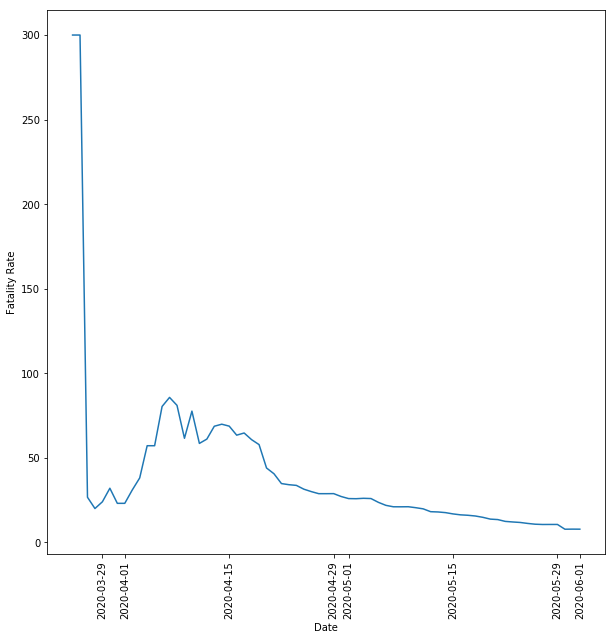

In [91]:
sns.lineplot(x=fatality_rate_maha.index, y=fatality_rate_maha['Fatality Rate'])
plt.xticks(rotation=90)
plt.show()

In [92]:
states = ['Maharashtra', 'Delhi', 'Gujarat', 'Kerela', 'Madhya Pradesh', "Uttar Pradesh"]

In [93]:
df_temp = fatality_df[fatality_df.State.isin(states)]

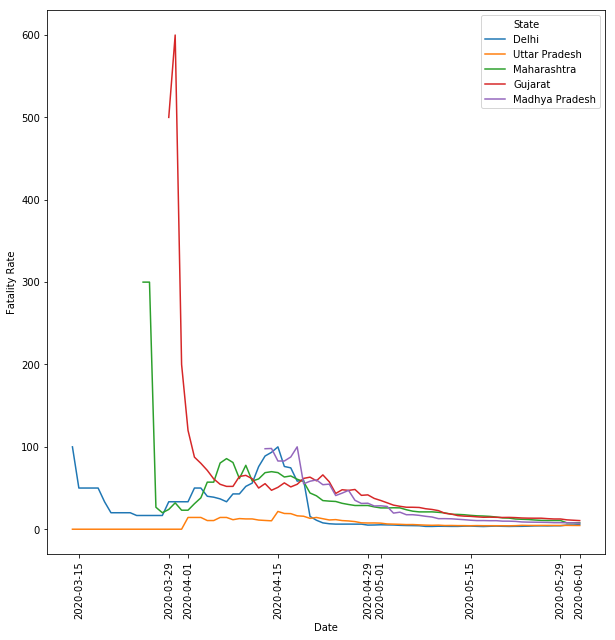

In [94]:
sns.lineplot(x=df_temp.index, y=df_temp['Fatality Rate'], hue=df_temp['State'])
plt.xticks(rotation=90)
plt.show()

In [95]:
aggregated_df.head()

Cured  Deaths  Confirmed  Active  Fatality Rate  \
Date       State                                                            
2020-06-01 West Bengal     2157     317       5501    3027      14.696338   
           Uttarakhand      102       5        907     800       4.901961   
           Uttar Pradesh   4709     213       7823    2901       4.523253   
           Tripura          173       0        313     140       0.000000   
           Tamil Nadu     12757     173      22333    9403       1.356118   

                          TotalSamples  Negative  Positive  Population  \
Date       State                                                         
2020-06-01 West Bengal             0.0       0.0       0.0    91276115   
           Uttarakhand             0.0       0.0       0.0    10086292   
           Uttar Pradesh           0.0       0.0       0.0   199812341   
           Tripura                 0.0       0.0       0.0     3673917   
           Tamil Nadu              0.0       0.0       0.0    72147030   

                          Rural population  Urban population  \
Date       State                                               
2020-06-01 West Bengal            62183113          29093002   
           Uttarakhand             7036954           3049338   
           Uttar Pradesh         155317278          44495063   
           Tripura                 2712464            961453   
           Tamil Nadu             37229590          34917440   

                                                Area                  Density  \
Date       State                                                                
2020-06-01 West Bengal     88,752 km2 (34,267 sq mi)  1,029/km2 (2,670/sq mi)   
           Uttarakhand     53,483 km2 (20,650 sq mi)      189/km2 (490/sq mi)   
           Uttar Pradesh  240,928 km2 (93,023 sq mi)    828/km2 (2,140/sq mi)   
           Tripura          10,486 km2 (4,049 sq mi)      350/km2 (910/sq mi)   
           Tamil Nadu     130,058 km2 (50,216 sq mi)    555/km2 (1,440/sq mi)   

                          Gender Ratio  Public Beds  Rural Beds  Urban Beds  
Date       State                                                             
2020-06-01 West Bengal             953        51163       19684       58882  
           Uttarakhand             963         6660        3284        5228  
           Uttar Pradesh           912        58310       39104       37156  
           Tripura                 960         4895        1140        3277  
           Tamil Nadu              996        72616       40179       37353

In [96]:
aggregated_df.loc[:, 'Total Beds'] = aggregated_df['Public Beds'] + aggregated_df['Rural Beds'] + aggregated_df['Urban Beds']

/home/akash/Dev/python/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2819: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


In [97]:
latest_df = aggregated_df.loc[aggregated_df.index.get_level_values(0) == '2020-06-01']
latest_df = latest_df.reset_index()
latest_df = latest_df.set_index('State')
latest_df = latest_df[latest_df.Confirmed > 1000]

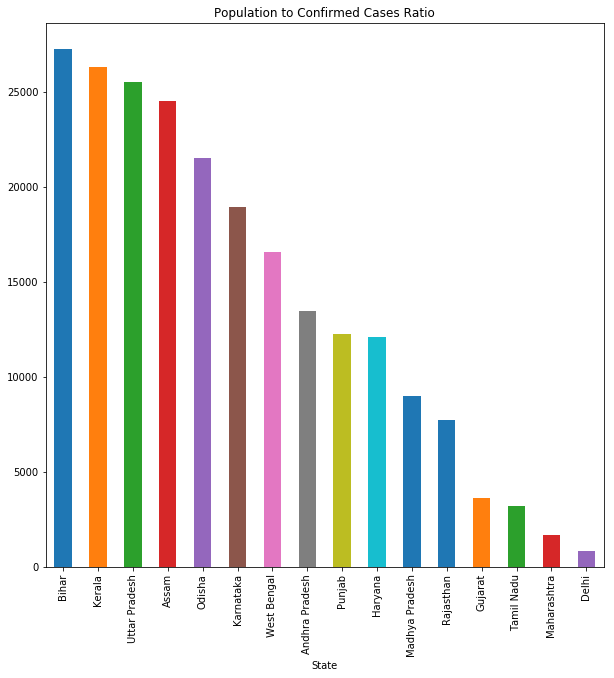

In [98]:
ser_pop_confirmed_ratio = (latest_df.Population / latest_df.Confirmed).sort_values(ascending=False)
ser_pop_confirmed_ratio.plot(kind='bar')
plt.title('Population to Confirmed Cases Ratio')
plt.show()

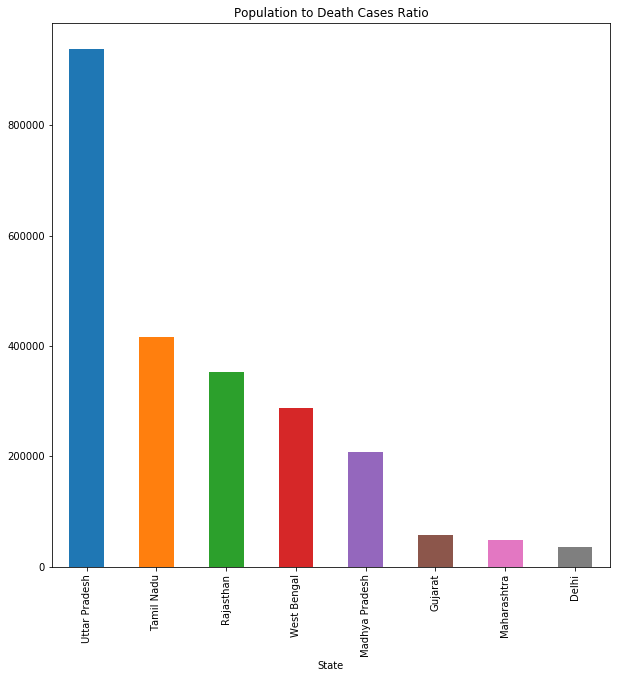

In [99]:
latest_df = aggregated_df.loc[aggregated_df.index.get_level_values(0) == '2020-06-01']
latest_df = latest_df.reset_index()
latest_df = latest_df.set_index('State')
latest_df = latest_df[latest_df.Deaths > 100]

ser_pop_deaths_ratio = (latest_df.Population / latest_df.Deaths).sort_values(ascending=False)
ser_pop_deaths_ratio.plot(kind='bar')
plt.title('Population to Death Cases Ratio')
plt.show()

In [100]:
ser_pop_deaths_ratio

State
Uttar Pradesh     938086.107981
Tamil Nadu        417034.855491
Rajasthan         353342.458763
West Bengal       287937.271293
Madhya Pradesh    207505.168571
Gujarat            58227.063584
Maharashtra        49157.625984
Delhi              35492.475687
dtype: float64

### Beds to Active Patients Ratio

In [101]:
latest_df = aggregated_df.loc[aggregated_df.index.get_level_values(0) == '2020-06-01', :].reset_index()
latest_df.loc[:, 'Beds/Active'] = latest_df['Total Beds'] / latest_df['Active']
df_least_beds_to_patients_ratio = latest_df.sort_values(by='Beds/Active', ascending=True).head(10)

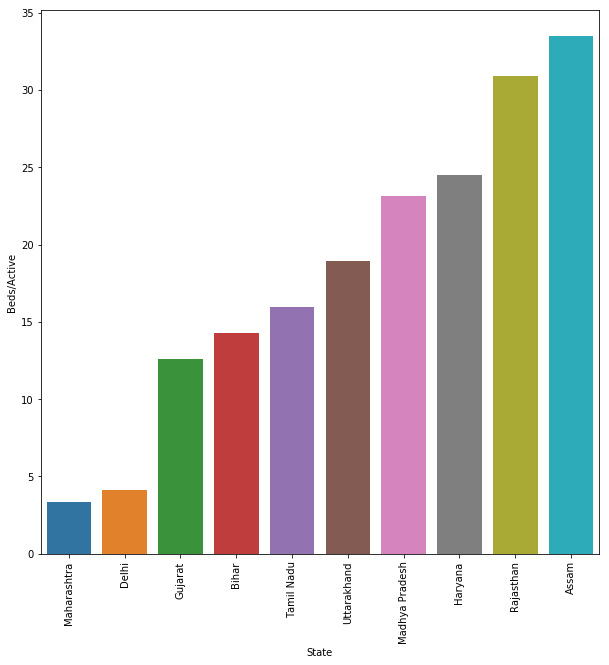

In [102]:
sns.barplot(x=df_least_beds_to_patients_ratio.State, y=df_least_beds_to_patients_ratio['Beds/Active'])
plt.xticks(rotation=90)
plt.show()

### Finding:

- As per above statistics, if we include only covid patients, there are only 3 beds available for 1 covid-19 patient in Maharashtra, which is alarming, given covid-19 is yet to peak.


- Also, there are only 4 beds available for 1 covid-19 patient in Delhi.

### Mortality rate per 1000000

In [108]:
latest_df.loc[:, 'Mortality/1000000'] = (latest_df['Deaths'] / latest_df['Population']) * 1000000
latest_df['Population_Density_square_km'] = latest_df['Density'].str.split('/').str[0]
latest_df.head()

,Date,State,Cured,Deaths,Confirmed,Active,Fatality Rate,TotalSamples,Negative,Positive,...,Area,Density,Gender Ratio,Public Beds,Rural Beds,Urban Beds,Total Beds,Beds/Active,Mortality/1000000,Population_Density_square_km
23,2020-06-01,Delhi,8478,473,19844,10893,5.579146,0.0,0.0,0.0,...,"1,484 km2 (573 sq mi)","11,297/km2 (29,260/sq mi)",868,20572,0,24383,44955,4.126962,28.174986,"11,297"
14,2020-06-01,Maharashtra,29329,2286,67655,36040,7.794333,0.0,0.0,0.0,...,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929,68998,12398,39048,120444,3.341953,20.342724,365
21,2020-06-01,Gujarat,9919,1038,16779,5822,10.464765,0.0,0.0,0.0,...,"196,024 km2 (75,685 sq mi)",308/km2 (800/sq mi),919,41129,11715,20565,73409,12.608897,17.174144,308
15,2020-06-01,Madhya Pradesh,4842,350,8089,2897,7.228418,0.0,0.0,0.0,...,"308,245 km2 (119,014 sq mi)",236/km2 (610/sq mi),931,38140,10020,18819,66979,23.120124,4.819157,236
25,2020-06-01,Chandigarh,199,4,293,90,2.010050,0.0,0.0,0.0,...,114 km2 (44 sq mi),"9,252/km2 (23,960/sq mi)",818,3756,0,778,4534,50.377778,3.789853,"9,252"


In [109]:
latest_df['Population_Density_square_km'] = latest_df['Population_Density_square_km'].str.replace(',', '')
latest_df['Population_Density_square_km'] = latest_df['Population_Density_square_km'].astype(np.int)

In [110]:
latest_df.head()

,Date,State,Cured,Deaths,Confirmed,Active,Fatality Rate,TotalSamples,Negative,Positive,...,Area,Density,Gender Ratio,Public Beds,Rural Beds,Urban Beds,Total Beds,Beds/Active,Mortality/1000000,Population_Density_square_km
23,2020-06-01,Delhi,8478,473,19844,10893,5.579146,0.0,0.0,0.0,...,"1,484 km2 (573 sq mi)","11,297/km2 (29,260/sq mi)",868,20572,0,24383,44955,4.126962,28.174986,11297
14,2020-06-01,Maharashtra,29329,2286,67655,36040,7.794333,0.0,0.0,0.0,...,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929,68998,12398,39048,120444,3.341953,20.342724,365
21,2020-06-01,Gujarat,9919,1038,16779,5822,10.464765,0.0,0.0,0.0,...,"196,024 km2 (75,685 sq mi)",308/km2 (800/sq mi),919,41129,11715,20565,73409,12.608897,17.174144,308
15,2020-06-01,Madhya Pradesh,4842,350,8089,2897,7.228418,0.0,0.0,0.0,...,"308,245 km2 (119,014 sq mi)",236/km2 (610/sq mi),931,38140,10020,18819,66979,23.120124,4.819157,236
25,2020-06-01,Chandigarh,199,4,293,90,2.010050,0.0,0.0,0.0,...,114 km2 (44 sq mi),"9,252/km2 (23,960/sq mi)",818,3756,0,778,4534,50.377778,3.789853,9252
